# 第8章: ニューラルネット
第6章で取り組んだニュース記事のカテゴリ分類を題材として，ニューラルネットワークでカテゴリ分類モデルを実装する．なお，この章ではPyTorch, TensorFlow, Chainerなどの機械学習プラットフォームを活用せよ．

In [1]:
# 再開するときに実行するコード
import torch
from torch import nn
from torch import optim
import string
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

# 保存されたファイルを読み込み
y_train = torch.load("data/y_train.pt")
x_train = torch.load("data/x_train.pt")
y_test = torch.load("data/y_test.pt")
x_test = torch.load("data/x_test.pt")
y_valid = torch.load("data/y_valid.pt")
x_valid = torch.load("data/x_valid.pt")

class SingleNN(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.fc = torch.nn.Linear(d_in, d_out, bias=False) # 全結合層
        torch.nn.init.normal_(self.fc.weight, 0.0, 1.0)
        
    def forward(self, x):
        x = self.fc(x)
        return x

criterion = nn.CrossEntropyLoss() # クロスエントロピー関数

C:\Users\kotem\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 70. 単語ベクトルの和による特徴量

https://yutaroogawa.github.io/pytorch_tutorials_jp/　チュートリアル

In [2]:
import gensim
# 学習済みモデルを使う場合はKeyedVectors.load_word2vec_format
model = gensim.models.KeyedVectors.load_word2vec_format("data/GoogleNews-vectors-negative300.bin",binary=True)

In [3]:
import torch
from torch import nn
from torch import optim
import string
import pandas as pd
import numpy as np

In [4]:
# 記事名を単語に分割してmodelにいれ、ベクトルを取得後に平均をとる
def ave_emb(text):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    words = text.translate(table).split()  # 記号をスペースに置換後、スペースで分割してリスト化
    vec = [model[word] for word in words if word in model] # 単語ごとにベクトル化
    return torch.tensor(sum(vec)/len(vec)) # 平均ベクトルをtorch型に変換して出力

X_train = pd.read_table("data/train.txt", header=None)
X_valid = pd.read_table("data/valid.txt", header=None)
X_test = pd.read_table("data/test.txt", header=None)
Column = ["TITLE", "CATEGORY"]
X_train.columns = Column
X_valid.columns = Column
X_test.columns = Column

# 正解ラベルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = torch.tensor(X_train["CATEGORY"].map(lambda x: category_dict[x]).values)
y_valid = torch.tensor(X_valid["CATEGORY"].map(lambda x: category_dict[x]).values)
y_test = torch.tensor(X_test["CATEGORY"].map(lambda x: category_dict[x]).values)

# 特徴ベクトルの作成
x_train = torch.stack([ave_emb(text) for text in X_train["TITLE"]])
x_valid = torch.stack([ave_emb(text) for text in X_valid["TITLE"]])
x_test = torch.stack([ave_emb(text) for text in X_test["TITLE"]])

print(x_test.size())
print(x_test)
print(y_test.size())
print(y_test)

# 保存
torch.save(x_train, 'data/x_train.pt')
torch.save(x_valid, 'data/x_valid.pt')
torch.save(x_test, 'data/x_test.pt')
torch.save(y_train, 'data/y_train.pt')
torch.save(y_valid, 'data/y_valid.pt')
torch.save(y_test, 'data/y_test.pt')

torch.Size([1334, 300])
tensor([[ 0.0419,  0.0430,  0.0165,  ..., -0.0242, -0.0294, -0.0309],
        [ 0.0318, -0.0128,  0.0698,  ..., -0.0695, -0.0061, -0.0018],
        [-0.0045,  0.0548,  0.0844,  ...,  0.1036,  0.0515, -0.0463],
        ...,
        [-0.0159,  0.0722,  0.0532,  ..., -0.0231,  0.0788, -0.0031],
        [ 0.0020,  0.0891, -0.0584,  ...,  0.0133,  0.0556,  0.0458],
        [ 0.0993,  0.0330,  0.0284,  ..., -0.0136,  0.0859,  0.0154]])
torch.Size([1334])
tensor([1, 3, 0,  ..., 2, 2, 1])


## 71. 単層ニューラルネットワークによる予測
d = 300, L = 4

In [5]:
class SingleNN(torch.nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.fc = torch.nn.Linear(d_in, d_out, bias=False) # 全結合層
        torch.nn.init.normal_(self.fc.weight, 0.0, 1.0)
        
    def forward(self, x):
        x = self.fc(x)
        return x

# 保存されたファイルを読み込み
y_train = torch.load("data/y_train.pt")
x_train = torch.load("data/x_train.pt")

network = SingleNN(300, 4)
print("y_hat_1", torch.softmax(network(x_train[:1]), dim=1))
print("Y_hat", torch.softmax(network(x_train[:4]), dim=1))

y_hat_1 tensor([[0.6545, 0.0447, 0.2201, 0.0807]], grad_fn=<SoftmaxBackward0>)
Y_hat tensor([[0.6545, 0.0447, 0.2201, 0.0807],
        [0.7681, 0.0351, 0.0445, 0.1523],
        [0.6710, 0.1388, 0.0712, 0.1190],
        [0.1751, 0.1660, 0.4002, 0.2587]], grad_fn=<SoftmaxBackward0>)


## 72. 損失と勾配の計算

In [6]:
criterion = nn.CrossEntropyLoss() # クロスエントロピー関数
loss = criterion(network(x_train[:1]), y_train[:1]) # 誤差を求める
network.zero_grad() # 勾配を0に
loss.backward() # 逆伝播(勾配を求める)
print(loss.item())
print(network.fc.weight.grad)

0.4238607585430145
tensor([[ 0.0059, -0.0455,  0.0251,  ..., -0.0136, -0.0077, -0.0063],
        [-0.0008,  0.0059, -0.0032,  ...,  0.0018,  0.0010,  0.0008],
        [-0.0037,  0.0290, -0.0160,  ...,  0.0087,  0.0049,  0.0040],
        [-0.0014,  0.0106, -0.0059,  ...,  0.0032,  0.0018,  0.0015]])


In [7]:
loss = criterion(network(x_train[:4]), y_train[:4])
network.zero_grad()
loss.backward()
print(loss.item())
print(network.fc.weight.grad)

0.7072722911834717
tensor([[ 0.0189, -0.0372,  0.0134,  ..., -0.0035, -0.0071, -0.0033],
        [-0.0045,  0.0064, -0.0020,  ..., -0.0001,  0.0033,  0.0014],
        [-0.0061,  0.0212, -0.0057,  ...,  0.0023,  0.0018,  0.0017],
        [-0.0083,  0.0096, -0.0057,  ...,  0.0013,  0.0020,  0.0002]])


## 73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，行列W
を学習せよ．なお，学習は適当な基準で終了させればよい（例えば「100エポックで終了」など）．

In [8]:
network = SingleNN(300, 4)
optimizer = optim.SGD(network.parameters(), lr=10) # 学習率lr = 10
for epoch in range(10000):
    optimizer.zero_grad() # 勾配を0に
    out = network(x_train) # 順伝搬
    pred = torch.softmax(out, dim=-1)
    loss = criterion(pred, y_train) # 誤差を求める
    loss.backward() # 逆伝播(勾配を求める)
    optimizer.step() # パラメータを更新
    if epoch % 500 == 0:
        print("epoch:{}, loss:{}".format(epoch,loss))

epoch:0, loss:1.4949002265930176
epoch:500, loss:0.8940460681915283
epoch:1000, loss:0.8584733605384827
epoch:1500, loss:0.8460538983345032
epoch:2000, loss:0.8396820425987244
epoch:2500, loss:0.8354830741882324
epoch:3000, loss:0.8323925137519836
epoch:3500, loss:0.8299652934074402
epoch:4000, loss:0.8279685378074646
epoch:4500, loss:0.8262710571289062
epoch:5000, loss:0.8247959017753601
epoch:5500, loss:0.8234966397285461
epoch:6000, loss:0.8223439455032349
epoch:6500, loss:0.8213163018226624
epoch:7000, loss:0.8203933835029602
epoch:7500, loss:0.8195577263832092
epoch:8000, loss:0.8187947869300842
epoch:8500, loss:0.8180933594703674
epoch:9000, loss:0.8174439668655396
epoch:9500, loss:0.8168391585350037


## 74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，その正解率をそれぞれ求めよ．

In [26]:
correct = 0
y = torch.softmax(network(x_train), dim=1)
for i, (x, t) in enumerate(zip(x_train, y_train)):
    correct += (y.argmax(1)[i] == t).sum().item()
print("訓練データ正解率:{}%".format(str(correct/(i+1)*100)))
correct = 0
y = torch.softmax(network(x_test), dim=1)
for i, (x, t) in enumerate(zip(x_test, y_test)):
    correct += (y.argmax(1)[i] == t).sum().item()
print("テストデータ正解率:{}%".format(str(correct/(i+1)*100)))

訓練データ正解率:94.06701099192159%
テストデータ正解率:89.39554612937434%


In [20]:
from sklearn.metrics import accuracy_score
y = network(x_train)
pred = torch.softmax(y, dim=1)
pred = pred.argmax(1)
print(accuracy_score(pred.detach().numpy().copy(),y_train.detach().numpy().copy()))

y = network(x_test)
pred = torch.softmax(y, dim=1)
pred = pred.argmax(1)
print(accuracy_score(pred.detach().numpy().copy(),y_test.detach().numpy().copy()))

0.9408025427095749
0.8950159066808059


## 75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，学習の進捗状況を確認できるようにせよ．

epoch:0, loss:1.3391976356506348
epoch:500, loss:0.9018835425376892
epoch:1000, loss:0.8624177575111389
epoch:1500, loss:0.8508394956588745
epoch:2000, loss:0.8444251418113708
epoch:2500, loss:0.8399308323860168
epoch:3000, loss:0.8364390730857849
epoch:3500, loss:0.8335774540901184
epoch:4000, loss:0.83116614818573
epoch:4500, loss:0.8290957808494568
epoch:5000, loss:0.8272808790206909
epoch:5500, loss:0.8256747722625732
epoch:6000, loss:0.8242918848991394
epoch:6500, loss:0.8230683207511902
epoch:7000, loss:0.8219637274742126
epoch:7500, loss:0.8209545612335205
epoch:8000, loss:0.8200244307518005
epoch:8500, loss:0.8191596269607544
epoch:9000, loss:0.8183489441871643
epoch:9500, loss:0.8175906538963318


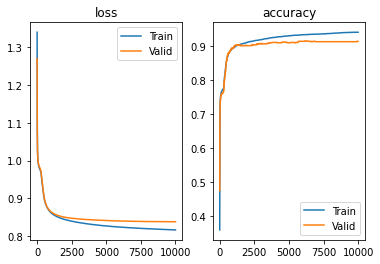

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
network = SingleNN(300, 4)
optimizer = optim.SGD(network.parameters(), lr=10) # 学習率lr = 10
# 損失のログ
record_loss_train = []
record_loss_valid = []
record_acc_train = []
record_acc_valid = []


for epoch in range(10000):
    optimizer.zero_grad() # 勾配を0に

    out = network(x_train) # 順伝搬
    pred = torch.softmax(out, dim=1)
    loss = criterion(pred, y_train) # 誤差を求める
    loss.backward() # 逆伝播(勾配を求める)
    optimizer.step() # パラメータを更新
    pred = pred.argmax(1)
    record_loss_train.append(loss.item()) # lossの追加
    # detachはtensor型から勾配情報を抜いたもの
    record_acc_train.append(float(accuracy_score(pred.detach().numpy().copy(),y_train.detach().numpy().copy()))) # accuracyの追加

    valid_out = network(x_valid)
    valid_pred = torch.softmax(valid_out, dim=1) 
    valid_loss = criterion(valid_pred, y_valid)
    valid_pred = valid_pred.argmax(1)
    record_loss_valid.append(valid_loss.item()) # lossの追加
    record_acc_valid.append(float(accuracy_score(valid_pred.detach().numpy().copy(),y_valid.detach().numpy().copy()))) # accuracyの追加

    if epoch % 500 == 0:
        print("epoch:{}, loss:{}".format(epoch,loss))

Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="Valid")
ax2.plot(range(len(record_acc_train)), record_acc_train, label="Train")
ax2.plot(range(len(record_acc_valid)), record_acc_valid, label="Valid")

ax1.set_title("loss")
ax2.set_title("accuracy")

ax1.legend()
ax2.legend()
plt.show()

## 76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態）をファイルに書き出せ．

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
network = SingleNN(300, 4)
optimizer = optim.SGD(network.parameters(), lr=10) # 学習率lr = 10



for epoch in range(10000):
    optimizer.zero_grad() # 勾配を0に

    out = network(x_train) # 順伝搬
    pred = torch.softmax(out, dim=1)
    loss = criterion(pred, y_train) # 誤差を求める
    loss.backward() # 逆伝播(勾配を求める)
    optimizer.step() # パラメータを更新
    pred = pred.argmax(1)
    # 学習情報の保存
    outfile = f'data/ans76/check_point_epoch_{epoch+1}.pt'
    torch.save({'epoch': epoch,
                'model_state_dict': network.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, outfile)

    if epoch % 500 == 0:
        print("epoch:{}, loss:{}".format(epoch,loss))


epoch:0, loss:1.3854334354400635
epoch:500, loss:0.8800615072250366
epoch:1000, loss:0.8578385710716248
epoch:1500, loss:0.8483337163925171
epoch:2000, loss:0.8425703048706055
epoch:2500, loss:0.8383642435073853
epoch:3000, loss:0.8349577784538269
epoch:3500, loss:0.8321800231933594
epoch:4000, loss:0.829876184463501
epoch:4500, loss:0.827911376953125
epoch:5000, loss:0.8262115120887756
epoch:5500, loss:0.8247236013412476
epoch:6000, loss:0.8234049081802368
epoch:6500, loss:0.8222243189811707
epoch:7000, loss:0.8211585283279419
epoch:7500, loss:0.8201895952224731
epoch:8000, loss:0.8193010687828064
epoch:8500, loss:0.8184787034988403
epoch:9000, loss:0.8177101612091064
epoch:9500, loss:0.8169859647750854


cpuでやったら14分かかった・・・

## 77. ミニバッチ化
問題76のコードを改変し，B
事例ごとに損失・勾配を計算し，行列W
の値を更新せよ（ミニバッチ化）．B
の値を1,2,4,8,…
と変化させながら，1エポックの学習に要する時間を比較せよ．

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.utils.data
import time

ds_train = torch.utils.data.TensorDataset(x_train, y_train)

batch_time = []
for batch_size in [2**i for i in range(0,10)]:
    print(f"start:batch_size {batch_size}")
    network = SingleNN(300, 4)
    optimizer = optim.SGD(network.parameters(), lr=10) # 学習率lr = 10
    # Dataloaderの設定
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    t_start = time.time()
    for epoch in range(100):
        for x, t in train_loader: # ミニバッチ(x, t)を取り出す
            optimizer.zero_grad() # 勾配を0に
            out = network(x) # 順伝搬
            pred = torch.softmax(out, dim=1)
            loss = criterion(pred, t) # 誤差を求める
            loss.backward() # 逆伝播(勾配を求める)
            optimizer.step() # パラメータを更新
    t_end = time.time()
    batch_time.append([batch_size, (t_end-t_start)/10])

start:batch_size 1
start:batch_size 2
start:batch_size 4
start:batch_size 8
start:batch_size 16
start:batch_size 32
start:batch_size 64
start:batch_size 128
start:batch_size 256
start:batch_size 512


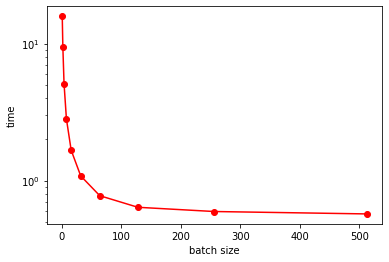

In [28]:
plt.plot([batch_size for batch_size,_ in batch_time],[time for _,time in batch_time], "-or")
plt.xlabel('batch size')
plt.ylabel('time')
plt.yscale('log')
plt.show()

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.utils.data
import time

ds_train = torch.utils.data.TensorDataset(x_train, y_train)

batch_time = []
for batch_size in [2**i for i in range(0,10)]:
    print(f"start:batch_size {batch_size}")
    network = SingleNN(300, 4)
    optimizer = optim.SGD(network.parameters(), lr=10) # 学習率lr = 10
    # Dataloaderの設定
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    t_start = time.time()
    for epoch in range(10):
        for x, t in train_loader: # ミニバッチ(x, t)を取り出す
            optimizer.zero_grad() # 勾配を0に
            out = network(x) # 順伝搬
            pred = torch.softmax(out, dim=1)
            loss = criterion(pred, t) # 誤差を求める
            loss.backward() # 逆伝播(勾配を求める)
            optimizer.step() # パラメータを更新
    t_end = time.time()
    batch_time.append([batch_size, (t_end-t_start)/10])

start:batch_size 1
start:batch_size 2
start:batch_size 4
start:batch_size 8
start:batch_size 16
start:batch_size 32
start:batch_size 64
start:batch_size 128
start:batch_size 256
start:batch_size 512


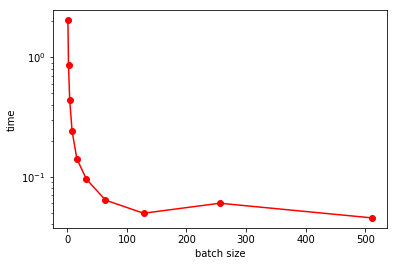

In [16]:
plt.plot([batch_size for batch_size,_ in batch_time],[time for _,time in batch_time], "-or")
plt.xlabel('batch size')
plt.ylabel('time')
plt.yscale('log')
plt.show()

## 78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.utils.data
import time

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
x_train = x_train.to(device)
y_train = y_train.to(device)
ds_train = torch.utils.data.TensorDataset(x_train, y_train)
batch_time_gpu = []
for batch_size in [2**i for i in range(0,10)]:
    print(f"start:batch_size {batch_size}")
    network = SingleNN(300, 4)
    network = network.to(device)  # GPU対応
    optimizer = optim.SGD(network.parameters(), lr=10) # 学習率lr = 10
    # Dataloaderの設定
    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    t_start = time.time()
    for epoch in range(10):
        for x, t in train_loader: # ミニバッチ(x, t)を取り出す
            x, t = x.to(device), t.to(device) # GPU対応
            optimizer.zero_grad() # 勾配を0に
            out = network(x) # 順伝搬
            pred = torch.softmax(out, dim=1)
            loss = criterion(pred, t) # 誤差を求める
            loss.backward() # 逆伝播(勾配を求める)
            optimizer.step() # パラメータを更新
    t_end = time.time()
    batch_time_gpu.append([batch_size, (t_end-t_start)/10])

cuda:0
start:batch_size 1
start:batch_size 2
start:batch_size 4
start:batch_size 8
start:batch_size 16
start:batch_size 32
start:batch_size 64
start:batch_size 128
start:batch_size 256
start:batch_size 512


In [ ]:
def train(epoch, model, optimizer, loss_fn, device):
    device = torch.device(device)
    model.train()
    model.to(device)
    
    for i, (X, y) in enumerate(loader_train):
        if torch.cuda.is_available():
            X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = loss_fn(y_hat, y)
        loss.backward()
        optimizer.step()

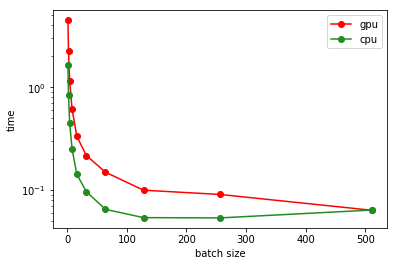

In [40]:
plt.plot([batch_size for batch_size,_ in batch_time],[time for _,time in batch_time_gpu], "-or", label="gpu")
plt.plot([batch_size for batch_size,_ in batch_time],[time for _,time in batch_time], "-or", label="cpu", color='forestgreen')
plt.xlabel('batch size')
plt.ylabel('time')
plt.yscale('log')
plt.legend()
plt.show()

In [30]:
print(device)

cuda:0


## 79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．

In [2]:
import torch.nn.functional as F
class MultiNet(nn.Module):
    def __init__(self, n_in, n_mid, n_out):
        super(MultiNet, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8907741251325557


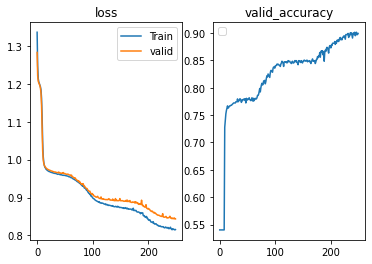

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch.utils.data


ds_train = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = DataLoader(ds_train, batch_size=512, shuffle=True)

record_loss_train = []
record_loss_valid = []
record_accuracy = []

network = MultiNet(300, 100, 4)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(network.parameters(), lr=0.5) # 学習率lr = 10
for epoch in range(250):
    loss_train = 0
    for j, (x, t) in enumerate(train_loader): # ミニバッチ(x, t)を取り出す
        optimizer.zero_grad() # 勾配を0に
        out = network(x) # 順伝搬
        pred = torch.softmax(out, dim=1)
        loss = criterion(pred, t) # 誤差を求める
        loss_train += loss.item()
        loss.backward() # 逆伝播(勾配を求める)
        optimizer.step() # パラメータを更新
    loss_train /= j+1
    record_loss_train.append(loss_train)
    valid_out = network(x_valid)
    valid_pred = torch.softmax(valid_out, dim=1)
    loss = criterion(valid_pred, y_valid) # 誤差を求める
    valid_pred = valid_pred.argmax(1)
    record_loss_valid.append(loss.item())
    record_accuracy.append(float(accuracy_score(valid_pred.detach().numpy().copy(),y_valid.detach().numpy().copy())))

y = network(x_test)
pred = torch.softmax(y, dim=1)
pred = pred.argmax(1)
print(accuracy_score(pred.detach().numpy().copy(),y_test.detach().numpy().copy()))

Figure = plt.figure()
ax1 = Figure.add_subplot(1,2,1)
ax2 = Figure.add_subplot(1,2,2)


ax1.plot(range(len(record_loss_train)), record_loss_train, label="Train")
ax1.plot(range(len(record_loss_valid)), record_loss_valid, label="valid")
ax2.plot(range(len(record_accuracy)), record_accuracy)

ax1.set_title("loss")
ax2.set_title("valid_accuracy")

ax1.legend()
ax2.legend()
plt.show()
